# Data Challenge 9 — Feature Engineering & Feature Selection

**Format:** Instructor Guidance → You Do (Students) → We Share (Reflection)

**Goal:** Engineer better predictors (one-hot/dummies, interactions, polynomials), avoid unnecessary complexity, and compare a **Base** vs **Engineered** model on the **same train–test split** using **MAE/RMSE**. Interpret coefficients in units and explain business value.



> Dataset: **NYC Yellow Taxi — Dec 2023** (CSV). Keep code *simple*: light numeric coercion only for your chosen columns.

## Instructor Guidance

**Hint: Use the Lecture Deck, Canvas Reading, and Docs to help you with the code**

**Docs (quick links):**
- One-hot encoding (pandas): https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html  
- OneHotEncoder (sklearn): https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html  
- Train/Test Split: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html  
- MAE / MSE / RMSE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html  
- OLS (statsmodels): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.OLS.html  
- OLS Results (coef/p/CIs/resid): https://www.statsmodels.org/stable/generated/statsmodels.regression.linear_model.RegressionResults.html

### Pseudocode Plan (Feature Engineering + Selection)
1) **Load CSV** → preview columns/shape.  
2) **Pick Y and initial Xs (2–3 numeric)** → keep it simple and decision-time-available.  
3) **Engineer features:**
   - **One-hot** a categorical with a dropped baseline (e.g., `payment_type` or `weekday/weekend`).  
   - **Interaction**: choose a hypothesis-driven pair (e.g., `trip_distance × is_weekend`).  
   - **Polynomial**: add one squared term for a plausible curve (e.g., `trip_distance²`).  
4) **Build Base vs Engineered design matrices** (add intercept).  
5) **Single train–test split** (80/20, fixed `random_state`) shared by both models.  
6) **Fit on TRAIN**, **predict on TEST** for both models; compute **MAE/RMSE** (units of Y).  
7) **Interpretation**: write unit-based coefficient sentences; note baseline category for dummies.  
8) **Light selection**: if Engineered model doesn’t beat Base on TEST (or adds complexity w/o value), prefer Base.  
9) **Diagnostics (quick)**: residuals vs fitted (train); note any cones (heteroskedasticity).  
10) **Stakeholder one-liner**: which model, why (TEST metrics in units), and what the added features *mean*.
markdown


## You Do — Student Section
Work in pairs. Comment your choices briefly. Keep code simple—only coerce the columns you use.

### Step 0 — Setup & Imports

In [109]:
import pandas as pd, numpy as np
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import scipy.stats as stats
from pathlib import Path


pd.set_option('display.float_format', lambda x: f'{x:,.4f}')

### Step 1 — Load CSV & Preview
- Point to your **Dec 2023** taxi CSV.
- Print **shape** and **columns**.

**Hint: You may have to drop missing values and do a force coercion to make sure the variables stay numeric (other coding assignments may help)**

In [110]:
# Load dataset
df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')
display(df.head())
display(df.info())
display(df.describe())

/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_67644/1234449748.py:2: DtypeWarning: Columns (4,10,13,16) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/Users/Marcy_Student/Desktop/Marcy_Lab/DA2025_Lectures/Mod6/data/2023_Yellow_Taxi_Trip_Data_20251015.csv')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,2,12/01/2023 04:11:39 PM,12/01/2023 04:19:13 PM,2.0000,0.69,1.0000,N,141,140,1,7.9000,2.5000,0.5000,3.0000,0.0000,1.0000,17.4000,2.5000,0.0000
1,1,12/01/2023 04:11:39 PM,12/01/2023 04:20:41 PM,3.0000,1.1,1.0000,N,236,263,2,10.0000,5.0000,0.5000,0.0000,0.0000,1.0000,16.5000,2.5000,0.0000
2,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,-10.7000,-2.5000,-0.5000,0.0000,0.0000,-1.0000,-17.2000,-2.5000,0.0000
3,2,12/01/2023 04:11:39 PM,12/01/2023 04:20:38 PM,1.0000,1.57,1.0000,N,48,239,4,10.7000,2.5000,0.5000,0.0000,0.0000,1.0000,17.2000,2.5000,0.0000
4,1,12/01/2023 04:11:39 PM,12/01/2023 04:34:39 PM,2.0000,3,1.0000,N,164,211,1,21.9000,5.0000,0.5000,3.0000,0.0000,1.0000,31.4000,2.5000,0.0000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3310907 entries, 0 to 3310906
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        float64
 4   trip_distance          object 
 5   RatecodeID             float64
 6   store_and_fwd_flag     object 
 7   PULocationID           int64  
 8   DOLocationID           int64  
 9   payment_type           int64  
 10  fare_amount            object 
 11  extra                  float64
 12  mta_tax                float64
 13  tip_amount             object 
 14  tolls_amount           float64
 15  improvement_surcharge  float64
 16  total_amount           object 
 17  congestion_surcharge   float64
 18  airport_fee            float64
dtypes: float64(8), int64(4), object(7)
memory usage: 479.9+ MB


None

,VendorID,passenger_count,RatecodeID,PULocationID,DOLocationID,payment_type,extra,mta_tax,tolls_amount,improvement_surcharge,congestion_surcharge,airport_fee
count,"3,310,907.0000","3,133,527.0000","3,133,527.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,310,907.0000","3,133,527.0000","3,133,527.0000"
mean,1.7504,1.4096,1.7850,165.0685,163.9182,1.1686,1.4852,0.4829,0.5734,0.9758,2.2700,0.1368
std,0.4356,0.9117,8.2833,64.2833,69.6845,0.5960,1.8141,0.1207,2.2285,0.2171,0.8078,0.4797
min,1.0000,0.0000,1.0000,1.0000,1.0000,0.0000,-39.1700,-0.5000,-70.0000,-1.0000,-2.5000,-1.7500
25%,1.0000,1.0000,1.0000,132.0000,113.0000,1.0000,0.0000,0.5000,0.0000,1.0000,2.5000,0.0000
50%,2.0000,1.0000,1.0000,162.0000,162.0000,1.0000,1.0000,0.5000,0.0000,1.0000,2.5000,0.0000
75%,2.0000,2.0000,1.0000,234.0000,234.0000,1.0000,2.5000,0.5000,0.0000,1.0000,2.5000,0.0000
max,6.0000,9.0000,99.0000,265.0000,265.0000,4.0000,51.6800,42.1700,161.3800,1.0000,2.5000,1.7500


In [111]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')


In [112]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
#df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])


/var/folders/h0/75t8pd8571n2l1zzjcyqp7kh0000gp/T/ipykernel_67644/1991085294.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])


In [113]:
df = df[(df['tpep_pickup_datetime'] >= '2023-12-01') & (df['tpep_pickup_datetime'] < '2024-01-01')]

### Step 2 —  Pick Target **Y** and Predictors **Xs** (choose 2–3 numeric)

- **Avoid** using an X that directly defines Y (e.g., `total_amount` when Y = `fare_amount`).
- Coerce **only these columns** to numeric; drop NA rows.

The response variable (Y) I chose is `fare_amount`, representing the fare charged for a taxi trip. I think this outcome is meaningful for my stakeholders taxi company, who aim to understand which trip factors most influence earnings. My stakeholders can act on this information to optimize pricing, scheduling, and customer service strategies.
And the x-variable I chose are `trip_distance` because longer trips lead to higher fares, this is the single strongest predictor of total amount, `passenger_count` because if the number of people increase, that could increase the fare amount as well meaning more effort for the driver sometimes to help with luggage, and `tpep_pickup_datetime` could also increase the fare amount because if the ride is during peak hour or late night, the fare amount can be influenced due to many factors.


In [114]:
# Coerce fare, tip, distance to numeric safely
num_cols = ['fare_amount', 'tip_amount', 'trip_distance', 'passenger_count', 'total_amount']
for c in num_cols:
    df[c] = pd.to_numeric(
        df[c].astype(str).str.strip().str.replace(r'[^0-9.+\-eE]', '', regex=True),
        errors='coerce')
# Clean data some and add a new column called ‘tip_pct’ as the target
df = df[(df['trip_distance'] > 0) & (df['passenger_count'] > 0) & (df['total_amount'] > 0) & (df['fare_amount'] > 0)]
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=num_cols)

In [115]:
list_col = ['fare_amount', 'trip_distance', 'passenger_count']
for _ in list_col:
    Q1 = df[_].quantile(0.25)
    Q3 = df[_].quantile(0.99)
    IQR = Q3 - Q1
    df = df[(df[_] >= Q1 - 1.5*IQR) & (df[_] <= Q3 + 1.5*IQR)]

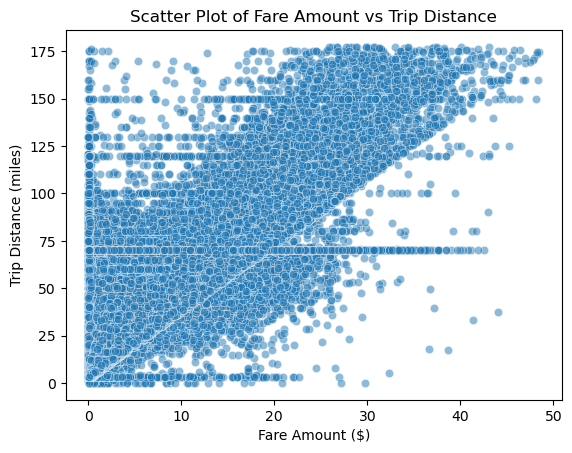

In [116]:
import seaborn as sns
sns.scatterplot(data=df, x='trip_distance', y='fare_amount', alpha=0.5)
plt.title('Scatter Plot of Fare Amount vs Trip Distance')
plt.xlabel('Fare Amount ($)')
plt.ylabel('Trip Distance (miles)')
plt.show()

### Step 3 —  Engineer New Features (One-hot, Interaction, Polynomial)

Pick **one** categorical to one-hot (drop baseline). Options that usually exist:

- `payment_type` (codes): treat as categorical strings for clarity, then one-hot with drop_first=True, or  
- derive **weekday/weekend** from `tpep_pickup_datetime` if present.

Then add **one interaction** and **one squared term** guided by a business hypothesis.

In [117]:
# --- 1. Interaction Term ---
df['distance_per_passenger'] = df['trip_distance'] * df['passenger_count']

# --- 2. Squared Term (for non-linear effect) ---
df['trip_distance_sq'] = df['trip_distance']**2 

In [118]:
df['is_peak'] = df['tpep_pickup_datetime'].dt.hour.between(7,9) | df['tpep_pickup_datetime'].dt.hour.between(16,19)

In [119]:
from sklearn.preprocessing import OneHotEncoder
# --- 1. Dummy Variables (Method: sklearn.OneHotEncoder) ---
# We fit the encoder on the 'is_peak' column
ohe = OneHotEncoder(drop='first', sparse_output=False)
feature_array = ohe.fit_transform(df[['is_peak']])
feature_labels = list(ohe.get_feature_names_out())
dummies_skl = pd.DataFrame(feature_array, columns=feature_labels)

In [120]:
dummies_skl.head()

,is_peak_True
0,1.0000
1,1.0000
2,1.0000
3,1.0000
4,1.0000


In [ ]:
import statsmodels.api as sm

# Define target and predictors
y_a = df['fare_amount']             
X_a = df[['trip_distance', 'passenger_count']]
X_a = sm.add_constant(X_a)

In [122]:
# Fit model
model_a = sm.OLS(y_a, X_a).fit()

# Summary
print(model_a.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.870
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                 1.010e+07
Date:                Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                        09:38:19   Log-Likelihood:            -9.7533e+06
No. Observations:             3014327   AIC:                         1.951e+07
Df Residuals:                 3014324   BIC:                         1.951e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               7.1834      0.007   10

In [123]:
# Concatenate back to the original dataframe
df_with_skl = pd.concat([df.reset_index(drop=True), dummies_skl.reset_index(drop=True)], axis=1)
print("\n--- Data with sklearn.OneHotEncoder ---")
df_with_skl.head()


--- Data with sklearn.OneHotEncoder ---


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,distance_per_passenger,trip_distance_sq,is_peak,is_peak_True
0,2,2023-12-01 16:11:39,12/01/2023 04:19:13 PM,2.0000,0.6900,1.0000,N,141,140,1,...,3.0000,0.0000,1.0000,17.4000,2.5000,0.0000,1.3800,0.4761,True,1.0000
1,1,2023-12-01 16:11:39,12/01/2023 04:20:41 PM,3.0000,1.1000,1.0000,N,236,263,2,...,0.0000,0.0000,1.0000,16.5000,2.5000,0.0000,3.3000,1.2100,True,1.0000
2,2,2023-12-01 16:11:39,12/01/2023 04:20:38 PM,1.0000,1.5700,1.0000,N,48,239,4,...,0.0000,0.0000,1.0000,17.2000,2.5000,0.0000,1.5700,2.4649,True,1.0000
3,1,2023-12-01 16:11:39,12/01/2023 04:34:39 PM,2.0000,3.0000,1.0000,N,164,211,1,...,3.0000,0.0000,1.0000,31.4000,2.5000,0.0000,6.0000,9.0000,True,1.0000
4,2,2023-12-01 16:11:40,12/01/2023 04:23:51 PM,1.0000,1.2400,1.0000,N,142,162,4,...,0.0000,0.0000,1.0000,17.9000,2.5000,0.0000,1.2400,1.5376,True,1.0000


### Step 4 — Build **Base** and **Engineered** Design Matrices

- **Engineered** = intercept + base predictors + engineered columns (dummies + interaction + polynomial)


In [136]:
import statsmodels.api as sm

# Define target and predictors
y_b = df['fare_amount']             
X_b = df_with_skl[['trip_distance', 'passenger_count', 'is_peak_True','distance_per_passenger', 'trip_distance_sq']]
X_b = sm.add_constant(X_b)   

### Step 5 — Single Train–Test Split (Shared by Both Models)

Use one split so Base and Engineered are comparable.

In [ ]:
# Fit model
from statsmodels.formula.api import ols
model_b = ols('fare_amount ~ trip_distance + is_peak + distance_per_passenger + trip_distance_sq', data=df_with_skl).fit() 

# Summary
print(model_b.summary())

                            OLS Regression Results                            
Dep. Variable:            fare_amount   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                 5.331e+06
Date:                Sat, 08 Nov 2025   Prob (F-statistic):               0.00
Time:                        10:15:53   Log-Likelihood:            -9.6815e+06
No. Observations:             3014327   AIC:                         1.936e+07
Df Residuals:                 3014322   BIC:                         1.936e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  5

### Step 6 — Fit on TRAIN, Predict on TEST, Compute **MAE/RMSE** (units of Y)

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Split data
#X = df[['trip_distance', 'passenger_count', 'distance_per_passenger', 'trip_distance_sq']]
#y = df['fare_amount']
X_b_train, X_b_test, y_train, y_b_test = train_test_split(X_b, y_b, test_size=0.2, random_state=42)

# Train model
lr = LinearRegression()
lr.fit(X_b_train, y_train)

# Predictions
y_pred = lr.predict(X_b_test)

# Evaluate
print("R²:", r2_score(y_b_test, y_pred))
print("RMSE:", mean_squared_error(y_b_test, y_pred))

R²: 0.8770958911638542
RMSE: 35.71675884487106


### Step 7 — Interpret Key Coefficients (Plain Language)


- **Dummy (is_peak):** Compared to baseline **[is_not_peak]**, the expected **fare amount** is **$5.98** higher/lower, holding other features constant.  
- **Interaction (passenger_count×is_peak):** On peak hours, each additional **1 mile** changes **fare amount** by **0.54** *more/less* than on regular time, holding other features constant. The fare amount also increases by $4.42 for each additional mile.  
- **Polynomial (distance²):** The marginal effect of distance changes with distance; the negative/positive β on distance² indicates **diminishing/increasing** returns.


### Step 8 —  Quick Diagnostics (Train Residuals) — Engineered Model
- **Residuals vs Fitted:** random cloud ≈ good; cone/funnel suggests non-constant variance.  
- **Q–Q plot:** points roughly along diagonal (normality for inference).  
- **Durbin–Watson:** printed in `eng_model.summary()` (~2 suggests independence).

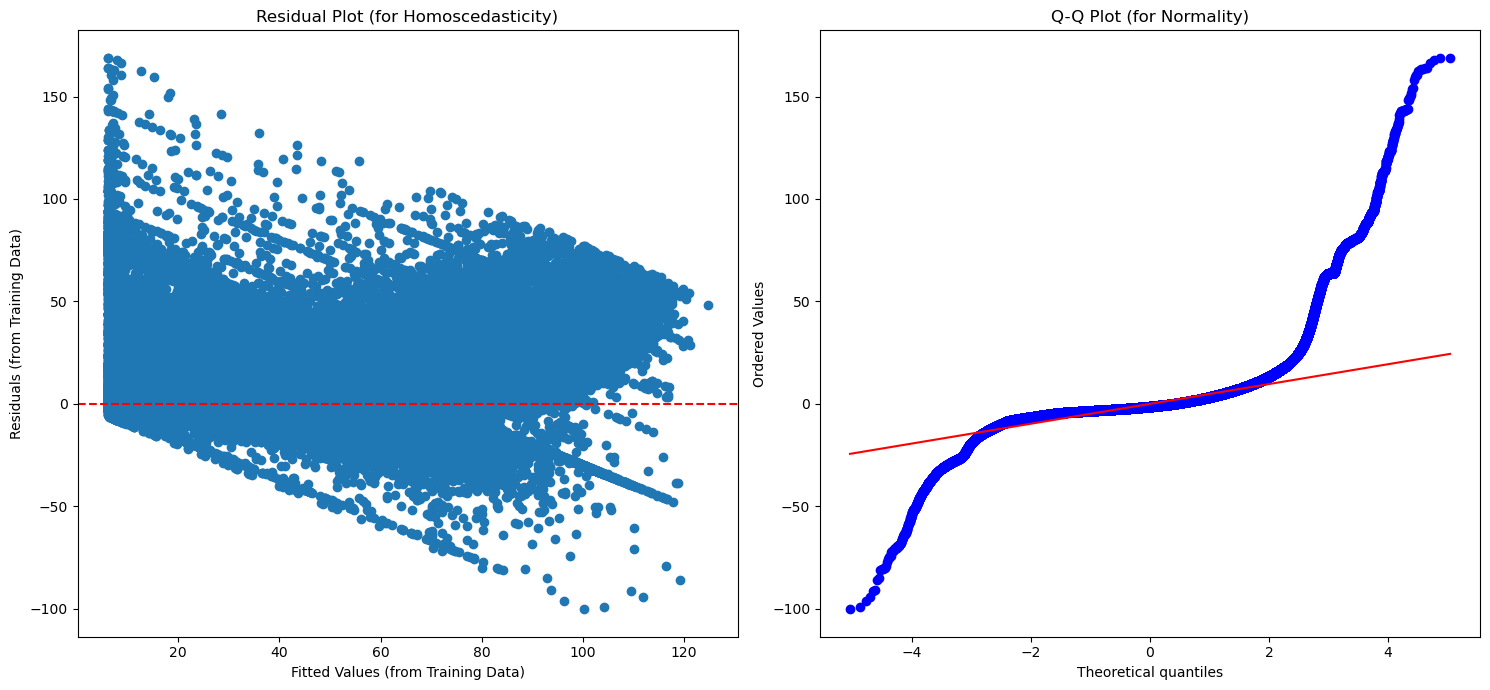

In [143]:
# Checking assumptions using the training data model 
# Residuals from the model trained on X_train, y_train
train_residuals = model_b.resid 

# 1. Plot for Homoscedasticity
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.scatter(model_b.fittedvalues, train_residuals)
plt.axhline(0, color='red', linestyle='--',)
plt.title('Residual Plot (for Homoscedasticity)')
plt.xlabel('Fitted Values (from Training Data)')
plt.ylabel('Residuals (from Training Data)')

# 2. Q-Q Plot for Normality
plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (for Normality)')

plt.tight_layout()
plt.show()

## We Share — Reflection & Wrap‑Up

**Notes on Feature Selection**
- If **Engineered** doesn’t beat **Base** on TEST (or gains are tiny), prefer **Base** for simplicity.  
- If two engineered features are redundant (e.g., highly correlated dummies), consider dropping one.  
- Keep features that improve TEST error **and** you can explain to a stakeholder.


Write **2 short paragraphs** and be specific:


1) **Which model would you deploy today—Base or Engineered—and why?**  
Use **TEST MAE/RMSE in units**, your coefficient interpretations (baseline/interaction/polynomial), and any residual observations.
- I will suggest deploying the Engineered model because it fits the data which it was trained on well, and the data is not likely to overfit. With an RMSE of 35.71, which is still lower than the base model, I think this is good for better accuracy when training the model to predict the fare amount.

2) **What engineered feature was most useful (or not)?**  
Explain the **business logic** behind it and whether it earned its place on the TEST set. If not, what would you try next (different interaction, different categorical, or simplifying features)?
- The `is_peak` feature was most useful to predict the fare amount because it helps us see other factors that can influence the fare, rather than just distance or passenger count. For business stakeholders, this is essential in predicting the fare because, generally during that time, taxi trips take longer due to other factors like congestion. Overall, I think trip_distance alone is not enough to predict the fare amount as it can be related to many other factors.
